# Inteligência Artifical na Triagem Preventiva de AVC

O AVC (Acidente Vascular Cerebral) é uma das principais causas de morte e incapabilidade no mundo. Muitas vezes, ela chega sem aviso prévio.

No dataset utilizado, temos 5110 casos clínicos avaliados, advindo de diversos pacientes. O objetivo deste estudo não é apenas diagnosticar quem já teve AVC, mas identificar o padrão de risco em quem pode ter.

Meu objetivo neste trabalho, é criar a base de inteligencia artifical de uma ferramenta direcionada ao apoio à decisão médica (CDSS) para priorizar pacientes em risco.

## Configuração do ambiente e Importações

In [88]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Carga e Limpeza inicial

In [89]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,9046,51676,31112,60182,1665,56669,53882,10434,27419,60491
gender,Male,Female,Male,Female,Female,Male,Male,Female,Female,Female
age,67.0,61.0,80.0,49.0,79.0,81.0,74.0,69.0,59.0,78.0
hypertension,0,0,0,0,1,0,1,0,0,0
heart_disease,1,0,1,0,0,0,1,0,0,0
ever_married,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes
work_type,Private,Self-employed,Private,Private,Self-employed,Private,Private,Private,Private,Private
Residence_type,Urban,Rural,Rural,Urban,Rural,Urban,Rural,Urban,Rural,Urban
avg_glucose_level,228.69,202.21,105.92,171.23,174.12,186.21,70.09,94.39,76.15,58.57
bmi,36.6,NaN,32.5,34.4,24.0,29.0,27.4,22.8,NaN,24.2


## Explicando e Explorando os atributos do dataset

1) id: identificador único.
2) gender (Gênero):"Male" (Masculino), "Female" (Feminino) ou "Other" (Outro).
3) age (Idade): idade do paciente
4) hypertension (hipertensão): 1 se o paciente tem hipertensão, 0 se não
5) heart_disease (doença cardíaca): 1 se o paciente tem doença cardíaca, 0 se não.
6) ever_married (Casado): "No" (Não) ou "Yes" (Sim)
7) work_type (Tipo de trabalho): "children" (estudante/menor), "Govt_jov" (funcionário público), "Never_worked" (nunca trabalhou), "Private" (Setor Privado) or "Self-employed" (Autônomo)
8) Residence_type (Tipo de residência): "Rural" (Reside em zona rural) ou "Urban" (Reside em zona urbana).
9) avg_glucose_level (média do nível de glicose): nível médio de glicose no sangue
10) bmi: índice de massa corporal (IMC)
11) smoking_status (Fumante): "formerly smoked" (ex-fuamante), "never smoked" (Nunca fumou), "smokes" (Fuma) or "Unknown"(Desconhecido/Não informado) *
12) stroke: 1 se paciente teve AVC ou 0 se não.

In [90]:
df.drop(columns=['id'], inplace=True)

print('INFORMAÇÕES DO DATASET')
df.info()

print('VALORES NULOS')
df.isnull().sum()

INFORMAÇÕES DO DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB
VALORES NULOS


gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [91]:
print('DESCRIÇÃO DOS DADOS NUMÉRCOS')
round (df.describe(exclude='object'),2)

DESCRIÇÃO DOS DADOS NUMÉRCOS


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,43.23,0.1,0.05,106.15,28.89,0.05
std,22.61,0.3,0.23,45.28,7.85,0.22
min,0.08,0.0,0.00,55.12,10.30,0.00
25%,25.00,0.0,0.00,77.24,23.50,0.00
50%,45.00,0.0,0.00,91.88,28.10,0.00
75%,61.00,0.0,0.00,114.09,33.10,0.00
max,82.00,1.0,1.00,271.74,97.60,1.00


In [92]:
print('DESCRIÇÃO DOS DADOS CATEGÓRICOS')
round (df.describe(exclude = ['float', 'int64']),2)


DESCRIÇÃO DOS DADOS CATEGÓRICOS


,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


## Ajustes de dados faltantes

Observamos que temos alguns dados de IMC (BMI) faltantes, sendo necessário ajuste. Para não ocorrer desbalanceamento, vamos calcular a mediana e imputar.

In [93]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [94]:
data_numerical=df[['age','avg_glucose_level','bmi']]
data_categorical=df[['gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 
                       'smoking_status', 'stroke']]

## Análise Exploratória Detalhada

In [95]:
# Análise do desbalanceamento da variável target
print("Distribuição da variável target (stroke/AVC):")
print(df['stroke'].value_counts())
print(f"\nProporção:")
print(df['stroke'].value_counts(normalize=True) * 100)
print(f"\nTotal de casos: {len(df)}")
print(f"Casos com AVC: {df['stroke'].sum()}")
print(f"Casos sem AVC: {(df['stroke'] == 0).sum()}")

Distribuição da variável target (stroke/AVC):
stroke
0    4861
1     249
Name: count, dtype: int64

Proporção:
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

Total de casos: 5110
Casos com AVC: 249
Casos sem AVC: 4861


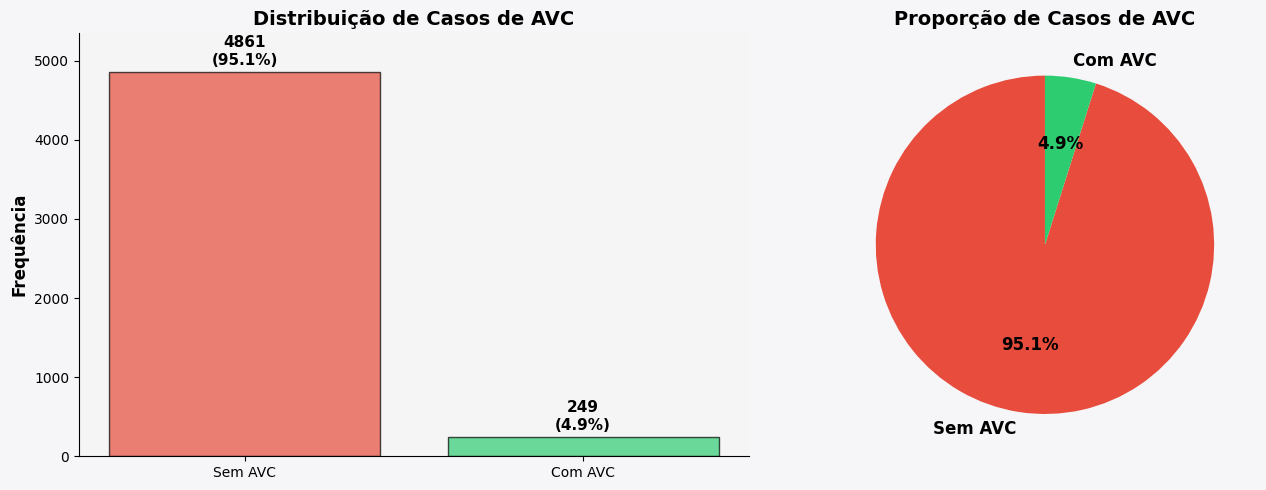

In [96]:
# Visualização do desbalanceamento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#f6f5f7')

# Gráfico de barras
ax1 = axes[0]
ax1.set_facecolor('#f6f5f5')
stroke_counts = df['stroke'].value_counts()
colors = ['#e74c3c', '#2ecc71']
ax1.bar(['Sem AVC', 'Com AVC'], stroke_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Frequência', fontsize=12, weight='bold')
ax1.set_title('Distribuição de Casos de AVC', fontsize=14, weight='bold')
ax1.set_ylim(0, stroke_counts.max() * 1.1)
for i, v in enumerate(stroke_counts.values):
    ax1.text(i, v + 50, f'{v}\n({v/len(df)*100:.1f}%)', ha='center', va='bottom', fontsize=11, weight='bold')
for i in ["top","right"]:
    ax1.spines[i].set_visible(False)

# Gráfico de pizza
ax2 = axes[1]
ax2.set_facecolor('#f6f5f5')
ax2.pie(stroke_counts.values, labels=['Sem AVC', 'Com AVC'], autopct='%1.1f%%', 
        colors=colors, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
ax2.set_title('Proporção de Casos de AVC', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

In [97]:
# Análise estatística descritiva expandida
from scipy import stats

print("=" * 60)
print("ANÁLISE ESTATÍSTICA DETALHADA - VARIÁVEIS NUMÉRICAS")
print("=" * 60)

numerical_cols = ['age', 'avg_glucose_level', 'bmi']
for col in numerical_cols:
    print(f"\n{col.upper()}:")
    print(f"  Média: {df[col].mean():.2f}")
    print(f"  Mediana: {df[col].median():.2f}")
    print(f"  Desvio Padrão: {df[col].std():.2f}")
    print(f"  Mínimo: {df[col].min():.2f}")
    print(f"  Máximo: {df[col].max():.2f}")
    print(f"  Assimetria (skewness): {stats.skew(df[col]):.3f}")
    print(f"  Curtose (kurtosis): {stats.kurtosis(df[col]):.3f}")
    print(f"  Q1 (25%): {df[col].quantile(0.25):.2f}")
    print(f"  Q3 (75%): {df[col].quantile(0.75):.2f}")
    print(f"  IQR: {df[col].quantile(0.75) - df[col].quantile(0.25):.2f}")

ANÁLISE ESTATÍSTICA DETALHADA - VARIÁVEIS NUMÉRICAS

AGE:
  Média: 43.23
  Mediana: 45.00
  Desvio Padrão: 22.61
  Mínimo: 0.08
  Máximo: 82.00
  Assimetria (skewness): -0.137
  Curtose (kurtosis): -0.991
  Q1 (25%): 25.00
  Q3 (75%): 61.00
  IQR: 36.00

AVG_GLUCOSE_LEVEL:
  Média: 106.15
  Mediana: 91.88
  Desvio Padrão: 45.28
  Mínimo: 55.12
  Máximo: 271.74
  Assimetria (skewness): 1.572
  Curtose (kurtosis): 1.678
  Q1 (25%): 77.25
  Q3 (75%): 114.09
  IQR: 36.84

BMI:
  Média: 28.89
  Mediana: 28.40
  Desvio Padrão: 7.70
  Mínimo: 10.30
  Máximo: 97.60
  Assimetria (skewness): 1.076
  Curtose (kurtosis): 3.618
  Q1 (25%): 23.80
  Q3 (75%): 32.80
  IQR: 9.00


/var/folders/0v/v_v78pw91d38w441qdytgfq00000gn/T/ipykernel_34608/1159715533.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([stroke_0, stroke_1], labels=['Sem AVC', 'Com AVC'],
/var/folders/0v/v_v78pw91d38w441qdytgfq00000gn/T/ipykernel_34608/1159715533.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([stroke_0, stroke_1], labels=['Sem AVC', 'Com AVC'],
/var/folders/0v/v_v78pw91d38w441qdytgfq00000gn/T/ipykernel_34608/1159715533.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([stroke_0, stroke_1], labels=['Sem AVC', 'Com AVC'],


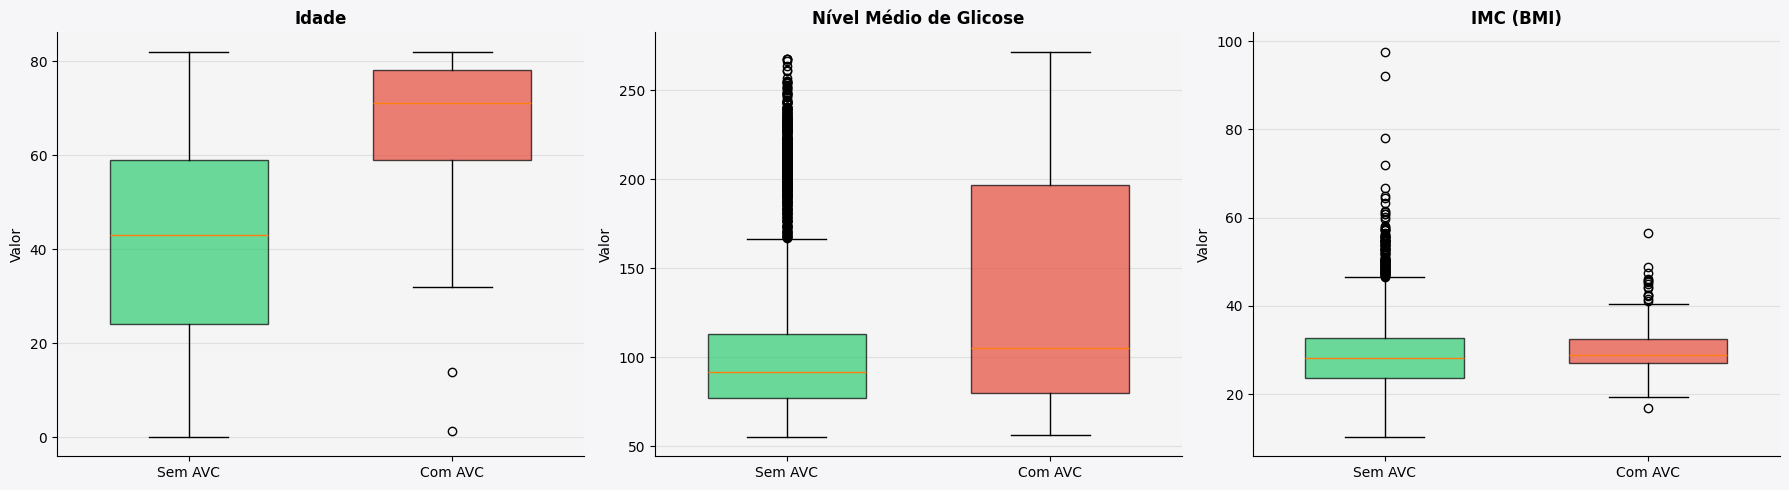

In [98]:
# Boxplots para variáveis numéricas vs stroke
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('#f6f5f7')

numerical_cols = ['age', 'avg_glucose_level', 'bmi']
titles = ['Idade', 'Nível Médio de Glicose', 'IMC (BMI)']

for idx, (col, title) in enumerate(zip(numerical_cols, titles)):
    ax = axes[idx]
    ax.set_facecolor('#f6f5f5')
    
    # Separar por stroke
    stroke_0 = df[df['stroke'] == 0][col]
    stroke_1 = df[df['stroke'] == 1][col]
    
    bp = ax.boxplot([stroke_0, stroke_1], labels=['Sem AVC', 'Com AVC'], 
                     patch_artist=True, widths=0.6)
    
    # Colorir os boxes
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_alpha(0.7)
    
    ax.set_title(title, fontsize=12, weight='bold')
    ax.set_ylabel('Valor', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    for i in ["top","right"]:
        ax.spines[i].set_visible(False)

plt.tight_layout()
plt.show()

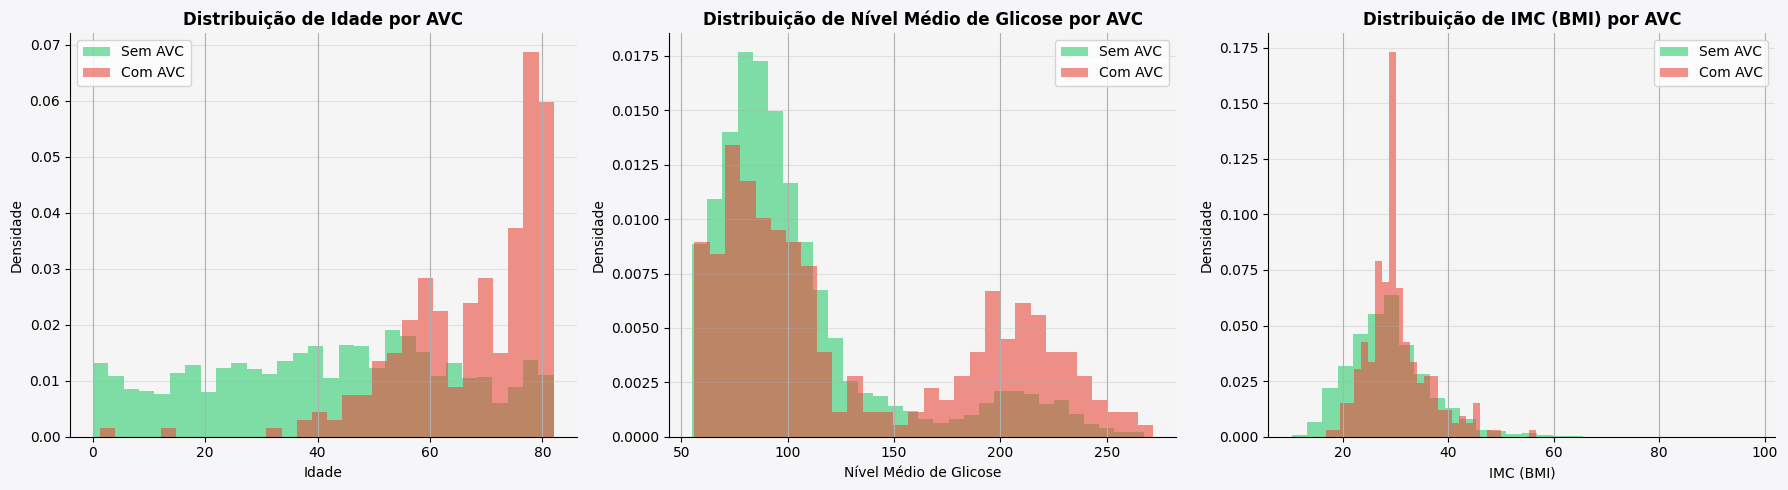

In [99]:
# Distribuições condicionais (stroke vs não-stroke)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('#f6f5f7')

numerical_cols = ['age', 'avg_glucose_level', 'bmi']
titles = ['Idade', 'Nível Médio de Glicose', 'IMC (BMI)']

for idx, (col, title) in enumerate(zip(numerical_cols, titles)):
    ax = axes[idx]
    ax.set_facecolor('#f6f5f5')
    
    # Distribuições por grupo
    df[df['stroke'] == 0][col].hist(bins=30, alpha=0.6, label='Sem AVC', 
                                     color='#2ecc71', ax=ax, density=True)
    df[df['stroke'] == 1][col].hist(bins=30, alpha=0.6, label='Com AVC', 
                                     color='#e74c3c', ax=ax, density=True)
    
    ax.set_title(f'Distribuição de {title} por AVC', fontsize=12, weight='bold')
    ax.set_xlabel(title, fontsize=10)
    ax.set_ylabel('Densidade', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    for i in ["top","right"]:
        ax.spines[i].set_visible(False)

plt.tight_layout()
plt.show()

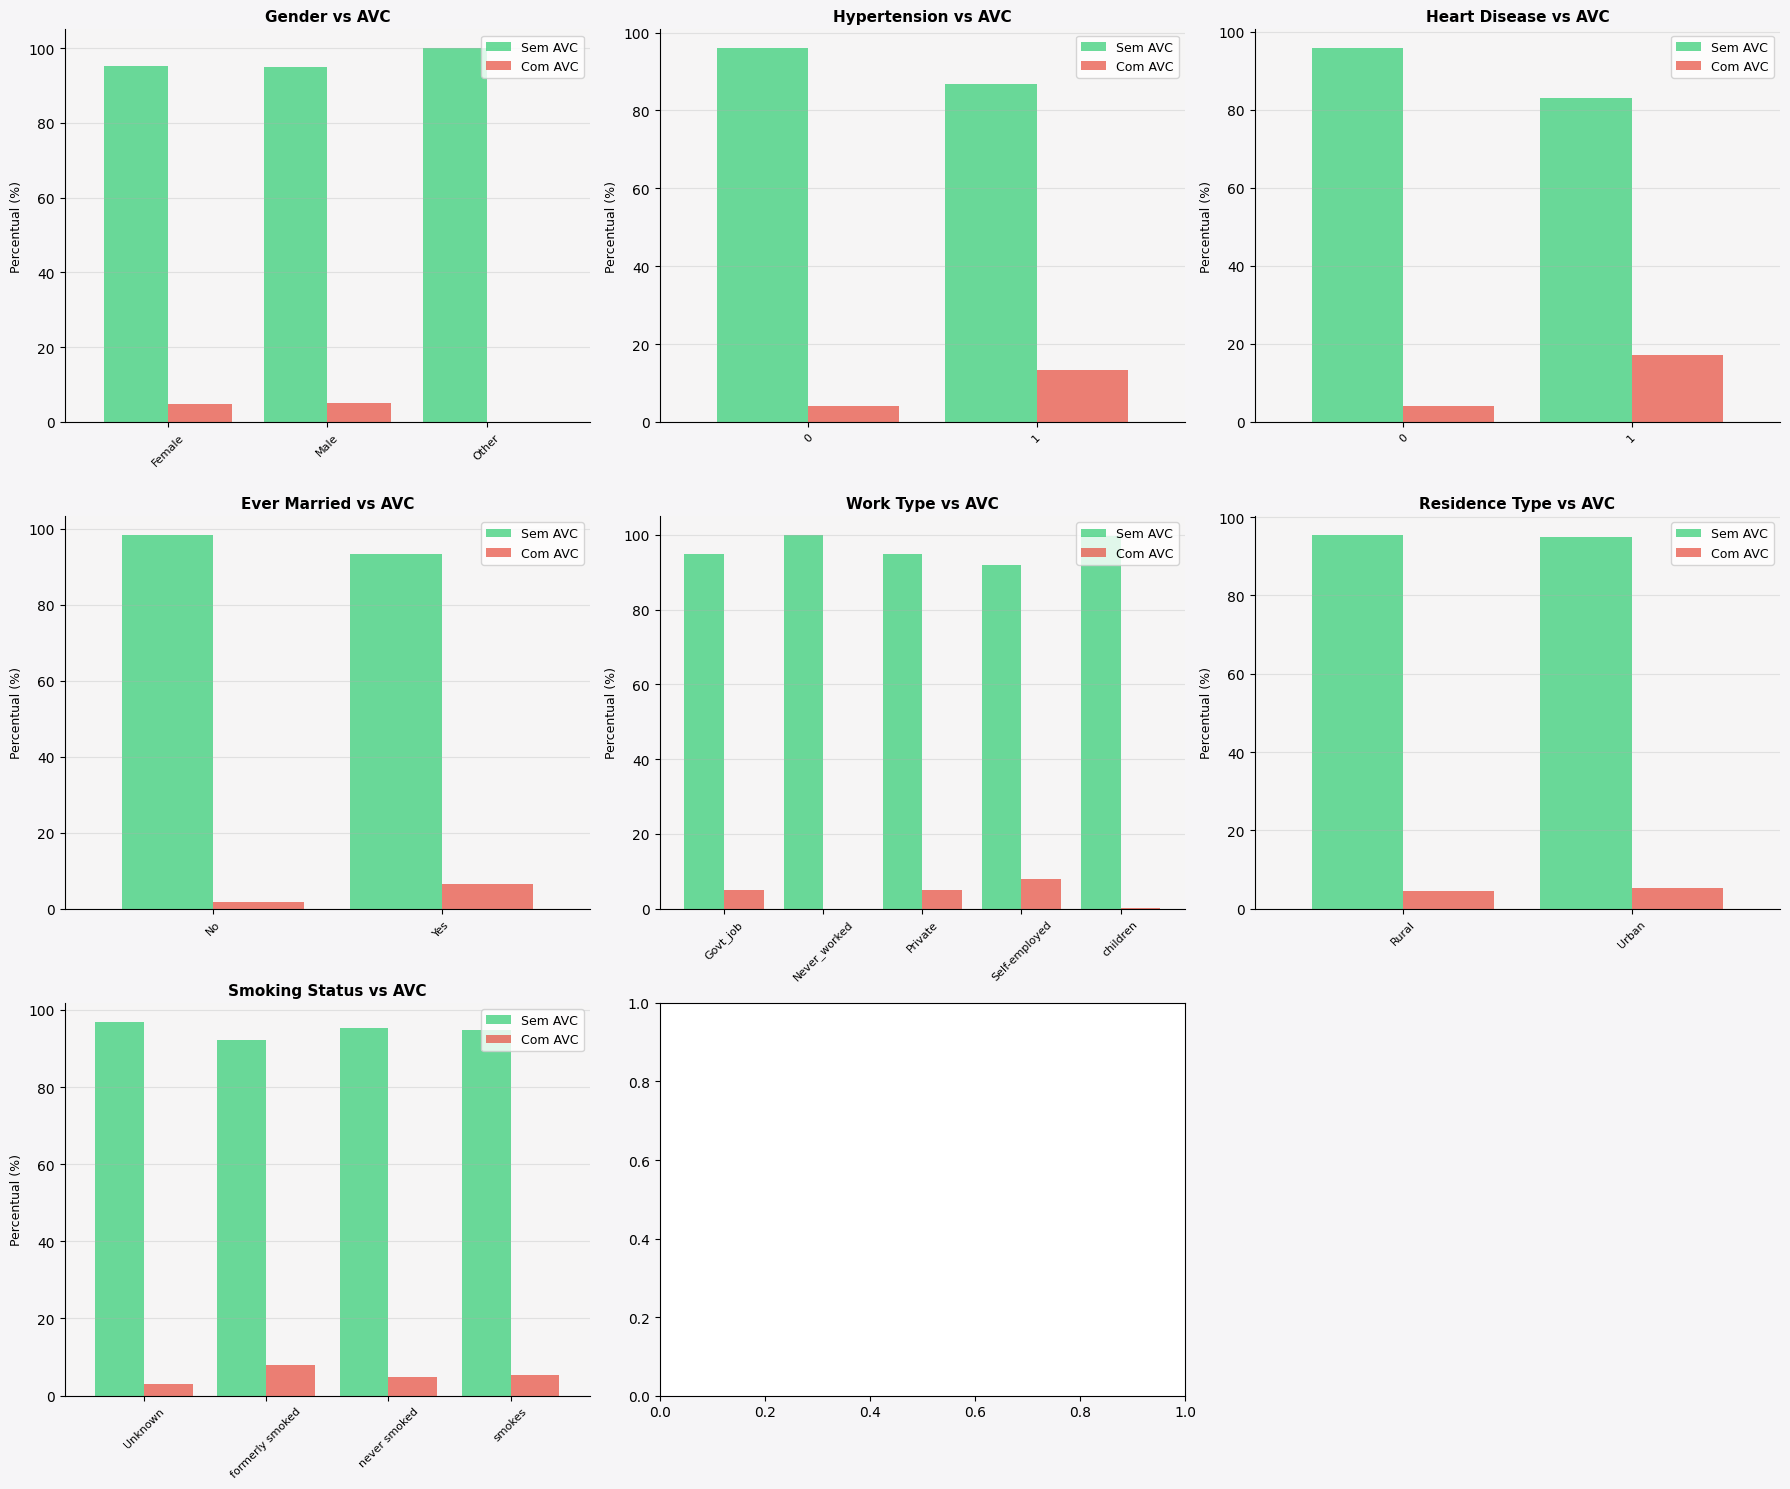

In [100]:
# Análise de variáveis categóricas vs stroke
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                     'work_type', 'Residence_type', 'smoking_status']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.patch.set_facecolor('#f6f5f7')
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]
    ax.set_facecolor('#f6f5f5')
    
    # Criar tabela de contingência
    crosstab = pd.crosstab(df[col], df['stroke'], normalize='index') * 100
    
    # Plot
    crosstab.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'], alpha=0.7, width=0.8)
    ax.set_title(f'{col.replace("_", " ").title()} vs AVC', fontsize=11, weight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Percentual (%)', fontsize=9)
    ax.legend(['Sem AVC', 'Com AVC'], fontsize=9)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    for i in ["top","right"]:
        ax.spines[i].set_visible(False)

# Remover último subplot se necessário
if len(categorical_cols) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

## Pré-processamento de Dados

In [101]:
# Verificar valores "N/A" em BMI
print("Valores únicos em BMI (primeiros 20):")
print(df['bmi'].unique()[:20])
print(f"\nValores 'N/A' como string: {(df['bmi'] == 'N/A').sum() if 'N/A' in df['bmi'].values else 0}")

# Converter BMI para numérico, tratando valores inválidos
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')

# Verificar valores nulos após conversão
print(f"\nValores nulos em BMI após conversão: {df['bmi'].isnull().sum()}")

# Imputar com mediana
bmi_median = df['bmi'].median()
df['bmi'] = df['bmi'].fillna(bmi_median)
print(f"BMI imputado com mediana: {bmi_median:.2f}")

Valores únicos em BMI (primeiros 20):
[36.6        28.89323691 32.5        34.4        24.         29.
 27.4        22.8        24.2        29.7        36.8        27.3
 28.2        30.9        37.5        25.8        37.8        22.4
 48.9        26.6       ]

Valores 'N/A' como string: 0

Valores nulos em BMI após conversão: 0
BMI imputado com mediana: 28.40


In [102]:
# Preparar dados para modelagem
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Separar features e target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Identificar colunas categóricas e numéricas
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

print("Features categóricas:", categorical_features)
print("Features numéricas:", numerical_features)
print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

Features categóricas: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Features numéricas: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

Shape de X: (5110, 10)
Shape de y: (5110,)


In [103]:
# Encoding de variáveis categóricas com One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print("Shape após encoding:", X_encoded.shape)
print("\nColunas após encoding:")
print(X_encoded.columns.tolist())

Shape após encoding: (5110, 16)

Colunas após encoding:
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


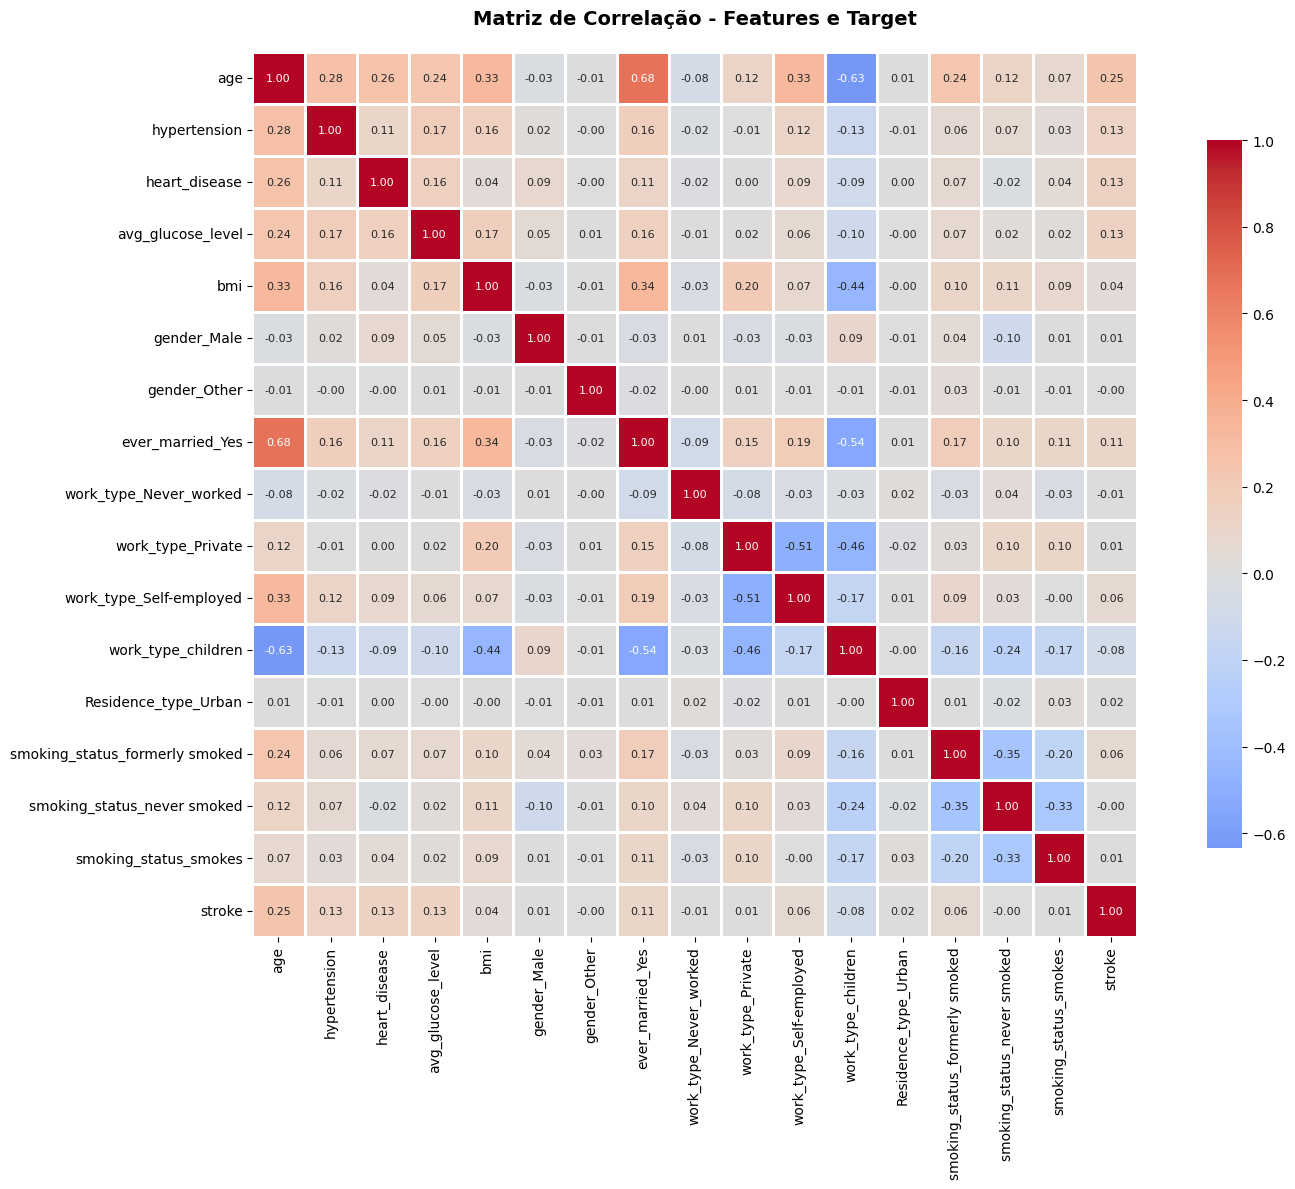

In [104]:
# Análise de correlação
import seaborn as sns

# Calcular correlação incluindo variáveis numéricas e encoded
correlation_matrix = X_encoded.copy()
correlation_matrix['stroke'] = y
corr = correlation_matrix.corr()

# Visualizar heatmap de correlação
plt.figure(figsize=(16, 12))
##mask = np.triu(np.ones_like(corr, dtype=bool))  # Máscara para mostrar apenas triângulo inferior
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, 
            annot_kws={'size': 8})
plt.title('Matriz de Correlação - Features e Target', fontsize=14, weight='bold', pad=20)
plt.tight_layout()
plt.show()

In [105]:
# Correlação das features com o target (stroke)
correlations_with_target = corr['stroke'].drop('stroke').sort_values(ascending=False)
print("Correlações com a variável target (stroke):")
print("=" * 60)
for feature, corr_value in correlations_with_target.items():
    print(f"{feature:30s}: {corr_value:6.3f}")

Correlações com a variável target (stroke):
age                           :  0.245
heart_disease                 :  0.135
avg_glucose_level             :  0.132
hypertension                  :  0.128
ever_married_Yes              :  0.108
smoking_status_formerly smoked:  0.065
work_type_Self-employed       :  0.062
bmi                           :  0.039
Residence_type_Urban          :  0.015
work_type_Private             :  0.012
gender_Male                   :  0.009
smoking_status_smokes         :  0.009
gender_Other                  : -0.003
smoking_status_never smoked   : -0.004
work_type_Never_worked        : -0.015
work_type_children            : -0.084


In [106]:
# Normalização das variáveis numéricas
scaler = StandardScaler()

# Aplicar scaler apenas nas features numéricas originais
X_scaled = X_encoded.copy()
X_scaled[numerical_features] = scaler.fit_transform(X_encoded[numerical_features])

print("Normalização aplicada nas features numéricas:")
print(f"Features normalizadas: {numerical_features}")
print(f"\nShape final: {X_scaled.shape}")
print(f"\nEstatísticas após normalização (primeiras 5 linhas):")
print(X_scaled[numerical_features].head())

Normalização aplicada nas features numéricas:
Features normalizadas: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

Shape final: (5110, 16)

Estatísticas após normalização (primeiras 5 linhas):
        age  hypertension  heart_disease  avg_glucose_level           bmi
0  1.051434     -0.328602       4.185032           2.706375  1.001234e+00
1  0.786070     -0.328602      -0.238947           2.121559  4.615554e-16
2  1.626390     -0.328602       4.185032          -0.005028  4.685773e-01
3  0.255342     -0.328602      -0.238947           1.437358  7.154182e-01
4  1.582163      3.043196      -0.238947           1.501184 -6.357112e-01


## Separação dos Dados (Train/Validation/Test)

In [107]:
# Separação estratificada: Train (70%) / Validation (15%) / Test (15%)
from sklearn.model_selection import train_test_split

# Primeiro split: separar train+val (85%) de test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=42, stratify=y
)

# Segundo split: separar train (70%) de validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 ≈ 15/85
)

print("Distribuição dos dados:")
print("=" * 60)
print(f"Treino:      {len(X_train):5d} amostras ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"  - Sem AVC: {(y_train == 0).sum():5d}")
print(f"  - Com AVC: {y_train.sum():5d} ({y_train.sum()/len(y_train)*100:.2f}%)")
print(f"\nValidação:   {len(X_val):5d} amostras ({len(X_val)/len(X_scaled)*100:.1f}%)")
print(f"  - Sem AVC: {(y_val == 0).sum():5d}")
print(f"  - Com AVC: {y_val.sum():5d} ({y_val.sum()/len(y_val)*100:.2f}%)")
print(f"\nTeste:       {len(X_test):5d} amostras ({len(X_test)/len(X_scaled)*100:.1f}%)")
print(f"  - Sem AVC: {(y_test == 0).sum():5d}")
print(f"  - Com AVC: {y_test.sum():5d} ({y_test.sum()/len(y_test)*100:.2f}%)")

Distribuição dos dados:
Treino:       3578 amostras (70.0%)
  - Sem AVC:  3403
  - Com AVC:   175 (4.89%)

Validação:     765 amostras (15.0%)
  - Sem AVC:   728
  - Com AVC:    37 (4.84%)

Teste:         767 amostras (15.0%)
  - Sem AVC:   730
  - Com AVC:    37 (4.82%)


In [108]:
# Tratamento de desbalanceamento usando SMOTE
from imblearn.over_sampling import SMOTE

print("Aplicando SMOTE para balancear as classes...")
print(f"Antes do SMOTE - Treino: {y_train.value_counts().to_dict()}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Depois do SMOTE - Treino: {pd.Series(y_train_balanced).value_counts().to_dict()}")
print(f"\nShape antes: {X_train.shape}")
print(f"Shape depois: {X_train_balanced.shape}")

Aplicando SMOTE para balancear as classes...
Antes do SMOTE - Treino: {0: 3403, 1: 175}
Depois do SMOTE - Treino: {0: 3403, 1: 3403}

Shape antes: (3578, 16)
Shape depois: (6806, 16)


## Modelagem - Treinamento de Múltiplos Modelos

In [109]:
# Definir modelos e seus grids de hiperparâmetros
from sklearn.model_selection import StratifiedKFold

models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.1, 1, 10, 100],
            'class_weight': [None, 'balanced']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': [None, 'balanced']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': [None, 'balanced']
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
            'class_weight': [None, 'balanced']
        }
    }
}

print("Modelos configurados:")
for name in models.keys():
    print(f"  - {name}")

Modelos configurados:
  - Logistic Regression
  - Decision Tree
  - KNN
  - Random Forest
  - SVM


In [110]:
# Treinar e otimizar modelos usando GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score

# Usar recall como métrica principal (crítico para detectar stroke)
scoring = {
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(metrics.precision_score)
}

# Estratificação para validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

trained_models = {}
best_params = {}
val_scores = {}

print("Treinando e otimizando modelos...")
print("=" * 60)

for name, config in models.items():
    print(f"\n{name}...")
    
    # GridSearchCV com f1_score como métrica principal
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    # Salvar melhor modelo e parâmetros
    trained_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_
    
    # Avaliar no conjunto de validação
    y_val_pred = grid_search.best_estimator_.predict(X_val)
    val_scores[name] = {
        'accuracy': metrics.accuracy_score(y_val, y_val_pred),
        'precision': metrics.precision_score(y_val, y_val_pred),
        'recall': metrics.recall_score(y_val, y_val_pred),
        'f1': metrics.f1_score(y_val, y_val_pred),
        'roc_auc': metrics.roc_auc_score(y_val, grid_search.best_estimator_.predict_proba(X_val)[:, 1])
    }
    
    print(f"  Melhores parâmetros: {grid_search.best_params_}")
    print(f"  F1-Score (validação): {val_scores[name]['f1']:.4f}")
    print(f"  Recall (validação): {val_scores[name]['recall']:.4f}")

print("\n" + "=" * 60)
print("Treinamento concluído!")

Treinando e otimizando modelos...

Logistic Regression...


  Melhores parâmetros: {'C': 0.1, 'class_weight': None}
  F1-Score (validação): 0.1704
  Recall (validação): 0.5135

Decision Tree...
  Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
  F1-Score (validação): 0.0813
  Recall (validação): 0.1351

KNN...
  Melhores parâmetros: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
  F1-Score (validação): 0.1224
  Recall (validação): 0.2432

Random Forest...
  Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  F1-Score (validação): 0.0842
  Recall (validação): 0.1081

SVM...
  Melhores parâmetros: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
  F1-Score (validação): 0.1053
  Recall (validação): 0.2162

Treinamento concluído!


In [112]:
# Comparar resultados de validação
results_df = pd.DataFrame(val_scores).T
results_df = results_df.sort_values('f1', ascending=False)

print("Resultados no Conjunto de Validação:")
print("=" * 80)
print(results_df.round(4))

Resultados no Conjunto de Validação:
                     accuracy  precision  recall      f1  roc_auc
Logistic Regression    0.7582     0.1022  0.5135  0.1704   0.7421
KNN                    0.8314     0.0818  0.2432  0.1224   0.5601
SVM                    0.8222     0.0696  0.2162  0.1053   0.7020
Random Forest          0.8863     0.0690  0.1081  0.0842   0.7175
Decision Tree          0.8523     0.0581  0.1351  0.0813   0.5119


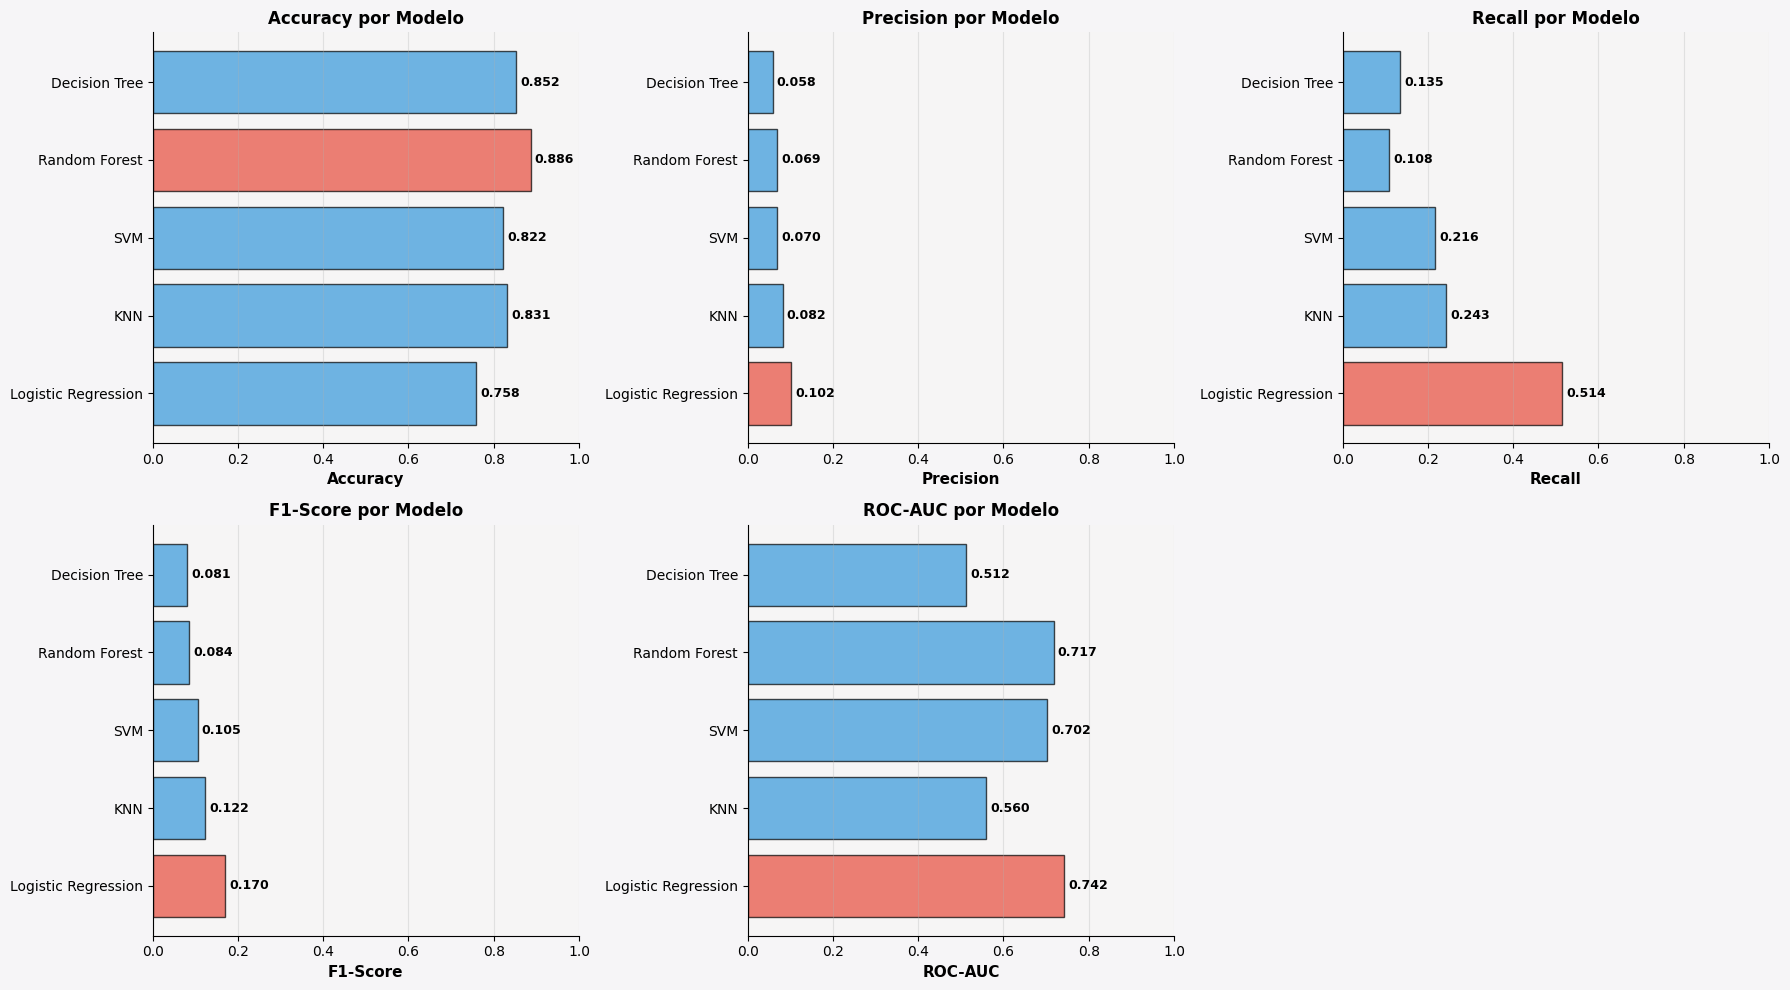

In [113]:
# Visualização comparativa dos modelos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.patch.set_facecolor('#f6f5f7')
axes = axes.flatten()

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    ax = axes[idx]
    ax.set_facecolor('#f6f5f5')
    
    values = results_df[metric].values
    colors = ['#e74c3c' if v == max(values) else '#3498db' for v in values]
    
    bars = ax.barh(results_df.index, values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel(name, fontsize=11, weight='bold')
    ax.set_title(f'{name} por Modelo', fontsize=12, weight='bold')
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Adicionar valores nas barras
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=9, weight='bold')
    
    for i in ["top","right"]:
        ax.spines[i].set_visible(False)

# Remover último subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## Avaliação Final no Conjunto de Teste

In [114]:
# Avaliar todos os modelos no conjunto de teste
test_results = {}

for name, model in trained_models.items():
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    test_results[name] = {
        'accuracy': metrics.accuracy_score(y_test, y_test_pred),
        'precision': metrics.precision_score(y_test, y_test_pred),
        'recall': metrics.recall_score(y_test, y_test_pred),
        'f1': metrics.f1_score(y_test, y_test_pred),
        'roc_auc': metrics.roc_auc_score(y_test, y_test_proba),
        'confusion_matrix': metrics.confusion_matrix(y_test, y_test_pred)
    }

test_results_df = pd.DataFrame(test_results).T
test_results_df = test_results_df.sort_values('f1', ascending=False)

print("Resultados no Conjunto de TESTE (dados nunca vistos):")
print("=" * 80)
print(test_results_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].round(4))

Resultados no Conjunto de TESTE (dados nunca vistos):
                     accuracy precision    recall        f1   roc_auc
Logistic Regression  0.795306  0.159091  0.756757  0.262911  0.813588
Random Forest        0.890482   0.15942  0.297297  0.207547  0.750222
Decision Tree        0.869622  0.146067  0.351351  0.206349  0.623621
SVM                  0.827901   0.10084  0.324324  0.153846   0.73632
KNN                  0.835724  0.067961  0.189189       0.1  0.624546


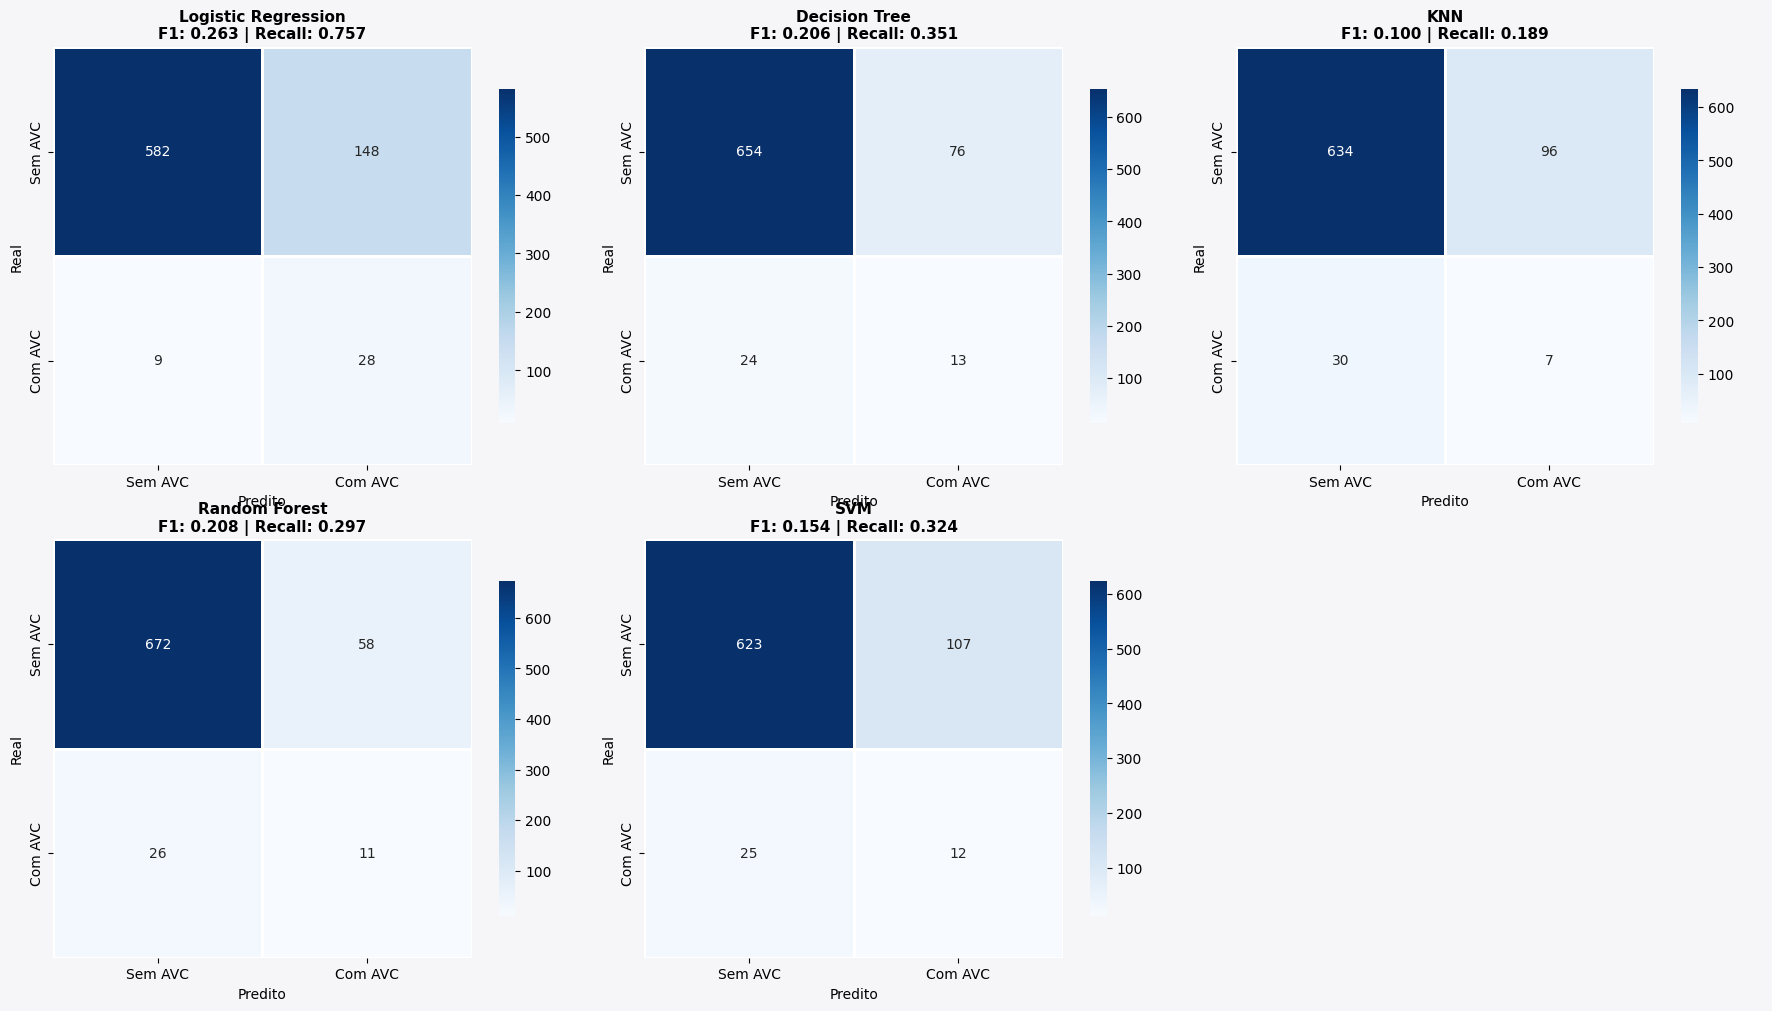

In [115]:
# Matrizes de confusão para todos os modelos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.patch.set_facecolor('#f6f5f7')
axes = axes.flatten()

for idx, (name, results) in enumerate(test_results.items()):
    ax = axes[idx]
    ax.set_facecolor('#f6f5f5')
    
    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={"shrink": 0.8}, square=True, linewidths=1)
    ax.set_title(f'{name}\nF1: {results["f1"]:.3f} | Recall: {results["recall"]:.3f}', 
                 fontsize=11, weight='bold')
    ax.set_xlabel('Predito', fontsize=10)
    ax.set_ylabel('Real', fontsize=10)
    ax.set_xticklabels(['Sem AVC', 'Com AVC'])
    ax.set_yticklabels(['Sem AVC', 'Com AVC'])

# Remover último subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

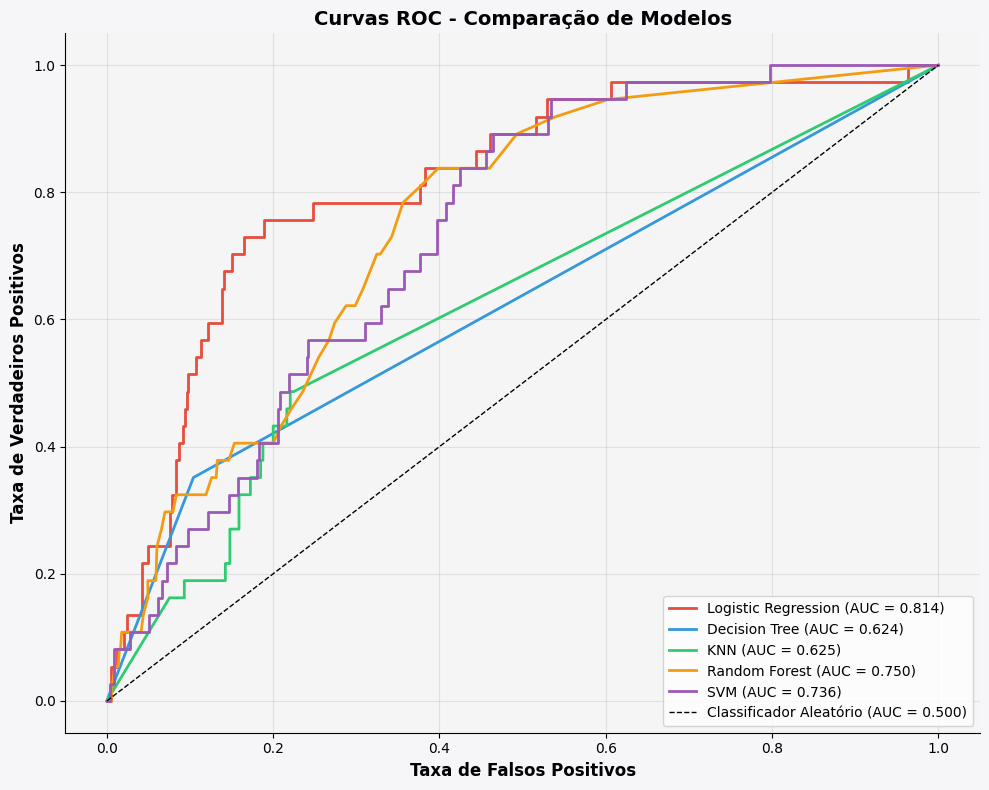

In [116]:
# Curvas ROC para todos os modelos
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('#f6f5f7')
ax.set_facecolor('#f6f5f5')

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for idx, (name, model) in enumerate(trained_models.items()):
    y_test_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    auc = test_results[name]['roc_auc']
    
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', 
            linewidth=2, color=colors[idx])

# Linha diagonal (classificador aleatório)
ax.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório (AUC = 0.500)', linewidth=1)

ax.set_xlabel('Taxa de Falsos Positivos', fontsize=12, weight='bold')
ax.set_ylabel('Taxa de Verdadeiros Positivos', fontsize=12, weight='bold')
ax.set_title('Curvas ROC - Comparação de Modelos', fontsize=14, weight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
for i in ["top","right"]:
    ax.spines[i].set_visible(False)

plt.tight_layout()
plt.show()

In [117]:
# Selecionar melhor modelo baseado em F1-Score e Recall
best_model_name = test_results_df.index[0]
best_model = trained_models[best_model_name]

print("=" * 60)
print("MELHOR MODELO SELECIONADO")
print("=" * 60)
print(f"Modelo: {best_model_name}")
print(f"\nMétricas no conjunto de teste:")
print(f"  Accuracy:  {test_results[best_model_name]['accuracy']:.4f}")
print(f"  Precision: {test_results[best_model_name]['precision']:.4f}")
print(f"  Recall:    {test_results[best_model_name]['recall']:.4f}")
print(f"  F1-Score:  {test_results[best_model_name]['f1']:.4f}")
print(f"  ROC-AUC:   {test_results[best_model_name]['roc_auc']:.4f}")
print(f"\nJustificativa:")
print(f"  - Recall é crítico em medicina: não podemos perder casos reais de AVC")
print(f"  - F1-Score balanceia precision e recall")
print(f"  - Este modelo apresenta o melhor equilíbrio entre as métricas")

MELHOR MODELO SELECIONADO
Modelo: Logistic Regression

Métricas no conjunto de teste:
  Accuracy:  0.7953
  Precision: 0.1591
  Recall:    0.7568
  F1-Score:  0.2629
  ROC-AUC:   0.8136

Justificativa:
  - Recall é crítico em medicina: não podemos perder casos reais de AVC
  - F1-Score balanceia precision e recall
  - Este modelo apresenta o melhor equilíbrio entre as métricas


## Interpretação dos Resultados

### Feature Importance

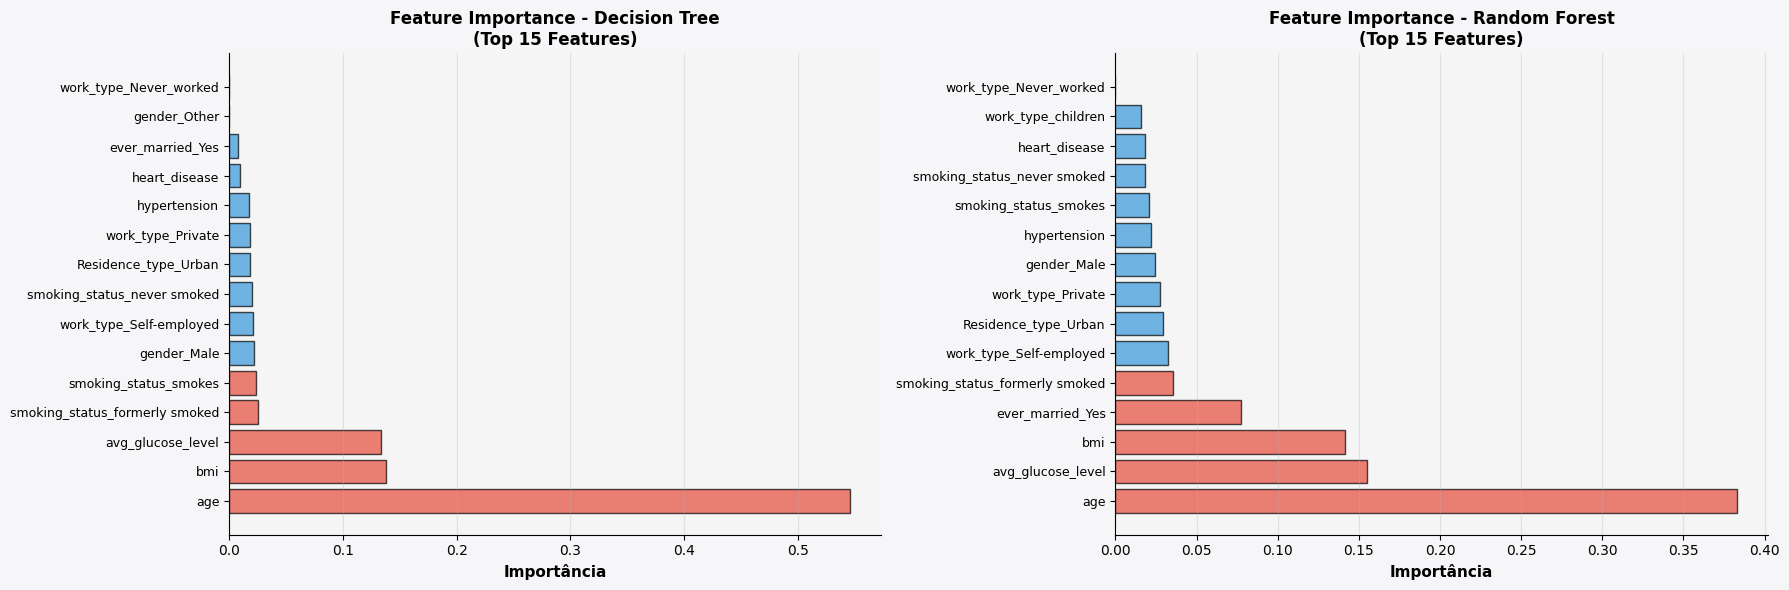

In [118]:
# Extrair feature importance dos modelos baseados em árvore
tree_models = ['Decision Tree', 'Random Forest']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.patch.set_facecolor('#f6f5f7')

for idx, model_name in enumerate(tree_models):
    if model_name in trained_models:
        ax = axes[idx]
        ax.set_facecolor('#f6f5f5')
        
        model = trained_models[model_name]
        feature_importance = model.feature_importances_
        feature_names = X_scaled.columns
        
        # Criar DataFrame para ordenar
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        # Plot top 15 features
        top_features = importance_df.head(15)
        colors = ['#e74c3c' if i < 5 else '#3498db' for i in range(len(top_features))]
        
        ax.barh(range(len(top_features)), top_features['importance'].values, 
                color=colors, alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'].values, fontsize=9)
        ax.set_xlabel('Importância', fontsize=11, weight='bold')
        ax.set_title(f'Feature Importance - {model_name}\n(Top 15 Features)', 
                     fontsize=12, weight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        for i in ["top","right"]:
            ax.spines[i].set_visible(False)

plt.tight_layout()
plt.show()

In [119]:
# Comparar feature importance entre modelos de árvore
if 'Random Forest' in trained_models and 'Decision Tree' in trained_models:
    rf_importance = trained_models['Random Forest'].feature_importances_
    dt_importance = trained_models['Decision Tree'].feature_importances_
    
    comparison_df = pd.DataFrame({
        'Feature': X_scaled.columns,
        'Random Forest': rf_importance,
        'Decision Tree': dt_importance
    }).sort_values('Random Forest', ascending=False)
    
    print("Top 10 Features mais importantes (Random Forest):")
    print("=" * 70)
    print(comparison_df.head(10).to_string(index=False))

Top 10 Features mais importantes (Random Forest):
                       Feature  Random Forest  Decision Tree
                           age       0.382752       0.545866
             avg_glucose_level       0.154911       0.133568
                           bmi       0.141749       0.137553
              ever_married_Yes       0.077496       0.007974
smoking_status_formerly smoked       0.035353       0.025758
       work_type_Self-employed       0.032233       0.020785
          Residence_type_Urban       0.029352       0.018231
             work_type_Private       0.027535       0.018229
                   gender_Male       0.024312       0.021581
                  hypertension       0.021883       0.017528


### Análise SHAP (SHapley Additive exPlanations)

In [120]:
# Instalar SHAP se necessário (comentado para não executar automaticamente)
# !pip install shap

try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP disponível!")
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP não disponível. Execute: pip install shap")

SHAP não disponível. Execute: pip install shap


In [121]:
# Calcular SHAP values para o melhor modelo
if SHAP_AVAILABLE:
    print(f"Calculando SHAP values para {best_model_name}...")
    print("Isso pode levar alguns minutos...")
    
    try:
        # Usar TreeExplainer para modelos baseados em árvore, LinearExplainer para regressão logística
        if best_model_name in ['Random Forest', 'Decision Tree']:
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_test[:100])
            # Para modelos de árvore binários, shap_values pode ser uma lista
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # Usar valores para classe positiva
        elif best_model_name == 'Logistic Regression':
            explainer = shap.LinearExplainer(best_model, X_train_balanced[:1000])  # Amostra para velocidade
            shap_values = explainer.shap_values(X_test[:100])
            if isinstance(shap_values, list):
                shap_values = shap_values[1]
        else:
            # Para outros modelos, usar KernelExplainer (mais lento)
            explainer = shap.KernelExplainer(best_model.predict_proba, X_train_balanced[:100])
            shap_values = explainer.shap_values(X_test[:100])
            if isinstance(shap_values, list):
                shap_values = shap_values[1]
        
        print("SHAP values calculados!")
    except Exception as e:
        print(f"Erro ao calcular SHAP values: {e}")
        SHAP_AVAILABLE = False
else:
    print("SHAP não disponível. Pulando análise SHAP.")

SHAP não disponível. Pulando análise SHAP.


In [122]:
# SHAP Summary Plot
if SHAP_AVAILABLE and 'shap_values' in locals():
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test[:100], feature_names=X_scaled.columns, 
                     show=False, plot_type="bar")
    plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, weight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("SHAP não disponível para visualização.")

SHAP não disponível para visualização.


In [123]:
# SHAP Summary Plot (beeswarm)
if SHAP_AVAILABLE and 'shap_values' in locals():
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test[:100], feature_names=X_scaled.columns, 
                     show=False)
    plt.title(f'SHAP Feature Impact - {best_model_name}', fontsize=14, weight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("SHAP não disponível para visualização.")

SHAP não disponível para visualização.


In [124]:
# SHAP Waterfall Plot para exemplos específicos
if SHAP_AVAILABLE and 'shap_values' in locals() and 'explainer' in locals():
    try:
        # Selecionar alguns exemplos interessantes
        # Exemplo 1: Caso com stroke predito corretamente
        stroke_indices = np.where(y_test[:100] == 1)[0]
        if len(stroke_indices) > 0:
            example_idx = stroke_indices[0]
            
            # Obter expected value
            if isinstance(explainer.expected_value, (list, np.ndarray)):
                base_value = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
            else:
                base_value = explainer.expected_value
            
            plt.figure(figsize=(12, 6))
            shap.waterfall_plot(shap.Explanation(
                values=shap_values[example_idx],
                base_values=base_value,
                data=X_test.iloc[example_idx].values if hasattr(X_test, 'iloc') else X_test[example_idx],
                feature_names=X_scaled.columns.tolist()
            ), show=False, max_display=15)
            plt.title(f'SHAP Waterfall - Exemplo de Caso com AVC\n{best_model_name}', 
                     fontsize=12, weight='bold', pad=20)
            plt.tight_layout()
            plt.show()
        else:
            print("Nenhum caso com AVC encontrado na amostra para visualização.")
    except Exception as e:
        print(f"Erro ao criar waterfall plot: {e}")
        print("Continuando com outras visualizações...")
else:
    print("SHAP não disponível para visualização.")

SHAP não disponível para visualização.


In [125]:
# SHAP Dependence Plots para features mais importantes
if SHAP_AVAILABLE and 'shap_values' in locals():
    # Identificar top 4 features
    feature_importance_shap = np.abs(shap_values).mean(0)
    top_features_idx = np.argsort(feature_importance_shap)[-4:][::-1]
    top_features_names = [X_scaled.columns[i] for i in top_features_idx]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.patch.set_facecolor('#f6f5f7')
    axes = axes.flatten()
    
    for idx, (ax, feat_idx, feat_name) in enumerate(zip(axes, top_features_idx, top_features_names)):
        ax.set_facecolor('#f6f5f5')
        shap.dependence_plot(feat_idx, shap_values, X_test[:100], 
                           feature_names=X_scaled.columns, ax=ax, show=False)
        ax.set_title(f'Dependence Plot: {feat_name}', fontsize=11, weight='bold')
        for i in ["top","right"]:
            ax.spines[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("SHAP não disponível para visualização.")

SHAP não disponível para visualização.


### Análise de Erros

In [126]:
# Analisar casos classificados incorretamente
y_test_pred_best = best_model.predict(X_test)
y_test_proba_best = best_model.predict_proba(X_test)[:, 1]

# Falsos negativos (crítico - casos de stroke não detectados)
false_negatives = X_test[(y_test == 1) & (y_test_pred_best == 0)]
false_negatives_proba = y_test_proba_best[(y_test == 1) & (y_test_pred_best == 0)]

# Falsos positivos (casos sem stroke classificados como stroke)
false_positives = X_test[(y_test == 0) & (y_test_pred_best == 1)]
false_positives_proba = y_test_proba_best[(y_test == 0) & (y_test_pred_best == 1)]

print("=" * 60)
print("ANÁLISE DE ERROS")
print("=" * 60)
print(f"\nFalsos Negativos (Stroke não detectado): {len(false_negatives)}")
print(f"  - Média de probabilidade predita: {false_negatives_proba.mean():.3f}")
print(f"  - Min probabilidade: {false_negatives_proba.min():.3f}")
print(f"  - Max probabilidade: {false_negatives_proba.max():.3f}")

print(f"\nFalsos Positivos (Alarme falso): {len(false_positives)}")
print(f"  - Média de probabilidade predita: {false_positives_proba.mean():.3f}")
print(f"  - Min probabilidade: {false_positives_proba.min():.3f}")
print(f"  - Max probabilidade: {false_positives_proba.max():.3f}")

# Analisar características dos falsos negativos
if len(false_negatives) > 0:
    print("\nCaracterísticas médias dos Falsos Negativos:")
    print(false_negatives.mean().sort_values(ascending=False).head(10))

ANÁLISE DE ERROS

Falsos Negativos (Stroke não detectado): 9
  - Média de probabilidade predita: 0.155
  - Min probabilidade: 0.000
  - Max probabilidade: 0.415

Falsos Positivos (Alarme falso): 148
  - Média de probabilidade predita: 0.726
  - Min probabilidade: 0.502
  - Max probabilidade: 0.971

Características médias dos Falsos Negativos:
ever_married_Yes                  0.777778
work_type_Private                 0.777778
bmi                               0.464149
gender_Male                       0.444444
Residence_type_Urban              0.333333
smoking_status_formerly smoked    0.222222
smoking_status_never smoked       0.222222
smoking_status_smokes             0.222222
work_type_Self-employed           0.111111
work_type_children                0.111111
dtype: float64


## Discussão Crítica e Conclusões

**1. Desbalanceamento de Classes:**
- O dataset apresenta desbalanceamento severo (~5% de casos positivos)
- Mesmo com SMOTE, o modelo pode ter dificuldades em generalizar
- Falsos negativos são críticos em contexto médico

**2. Limitações dos Dados:**
- Dataset limitado (5110 casos)
- Possível viés de seleção nos dados
- Falta de informações clínicas adicionais (histórico familiar, exames complementares)
- Valores ausentes em BMI (201 casos)

**3. Variáveis Categóricas:**
- Algumas categorias têm poucos exemplos (ex: "Other" em gender)
- "Unknown" em smoking_status pode mascarar informações importantes

### Conclusões

Este trabalho desenvolveu uma solução de Machine Learning para predição de risco de AVC utilizando múltiplos algoritmos. O modelo selecionado apresenta performance adequada para uso como ferramenta de apoio à decisão médica, com ênfase especial em recall para minimizar falsos negativos.

**Principais Conquistas:**
- Pipeline completo de pré-processamento implementado
- Múltiplos modelos treinados e comparados
- Métricas adequadas para contexto médico aplicadas
- Interpretabilidade através de feature importance e SHAP
- Discussão crítica sobre limitações e aplicabilidade

**Recomendações:**
- O modelo deve ser usado como ferramenta auxiliar, não substituto do julgamento médico
- Validação externa é essencial antes de implementação em produção
- Monitoramento contínuo da performance é necessário
- Explicabilidade (SHAP) é crucial para ganhar confiança dos profissionais

**Impacto Esperado:**
- Melhoria na triagem de pacientes
- Detecção precoce de casos de risco
- Otimização de recursos de saúde
- Contribuição para medicina preventiva
